## PCA Visualization & Evaluation Example
#### Example: Runescape - Darkscape

In [118]:
import os
import pickle
from AlignmentFormat import load_kv
import matplotlib.pyplot as plt
import numpy as np
from utils import get_emb_matrices, evaluate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from projections import ORTH_Projection
import faiss
from collections import Counter

In [119]:
with open("./training-monolingual/lexicon/train_lexicon_runescape-darkscape", "rb") as train:
    train_lexicon = pickle.load(train)
with open("./training-monolingual/lexicon/test_lexicon_runescape-darkscape", "rb") as test:
    test_lexicon = pickle.load(test)

In [120]:
# first 10 translation pairs
test_lexicon[:10]

[('<http://dbkwik.webdatacommons.org/runescape/resource/Pieces_of_eight>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Pieces_of_eight>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Sunnel>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Sunnel>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Rometti>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Rometti>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Kikazaru>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Kikazaru>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Chomp>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Chomp>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Ruby_key>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Ruby_key>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Murcaily>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Murcaily>'),
 ('<http://dbkwik.webdatacommons.org/ru

In [121]:
src_kv, tgt_kv = load_kv(src="runescape", tgt="darkscape") #size_src/size_tgt=200, ws=10

In [122]:
emb_src, emb_tgt = get_emb_matrices(src_kv, tgt_kv, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)

In [123]:
projection = ORTH_Projection(src_kv, tgt_kv, train_lexicon, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)
precisions = evaluate(projection.test_matrix_src, projection.test_matrix_tgt, projection.W, normalize=True)
X_src_projected = emb_src @ projection.W

The precision@ 1 is: 0.19
The precision@ 5 is: 0.428
The precision@ 10 is: 0.5


In [124]:
def visualize_PCA(start=0, end=5, annotate=True, save_file=None):
    projection = ORTH_Projection(src_kv, tgt_kv, train_lexicon, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)
    X_src_projected = emb_src @ projection.W
    
    span = list(range(start,end))
    n = []
    for pair in np.array(test_lexicon)[span,:]:
        n.append(pair[0].split("/")[-1][:-1])

    normalizer_1 = preprocessing.Normalizer(norm='l2')
    normalizer_2 = preprocessing.Normalizer(norm='l2')

    X_src = normalizer_1.fit_transform(emb_src.T).T
    X_tgt = normalizer_1.transform(emb_tgt.T).T


    pca = PCA(n_components=2)
    X_src_lowdim = pca.fit_transform(X_src)
    X_tgt_lowdim = pca.transform(X_tgt)

    X_src_lowdim = normalizer_2.fit_transform(X_src_lowdim.T).T
    X_tgt_lowdim = normalizer_2.transform(X_tgt_lowdim.T).T

    X_src_projected = normalizer_1.transform(X_src_projected.T).T
    X_src_lowdim_projected = pca.transform(X_src_projected)
    X_src_lowdim_projected = normalizer_2.transform(X_src_lowdim_projected.T).T
    
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(X_src_lowdim[span,0], X_src_lowdim[span,1], label='runescape', c='blue',alpha=1.0)
    ax.scatter(X_src_lowdim_projected[span,0], X_src_lowdim_projected[span,1], label='runescape_projected', c='lightgreen',alpha=1.0)
    ax.scatter(X_tgt_lowdim[span,0], X_tgt_lowdim[span,1], label='darkscape', c='red',alpha=1.0)
    if annotate:
        for i, txt in zip(span,n):
            ax.annotate(txt, (X_src_lowdim[i,0], X_src_lowdim[i,1]))
            ax.annotate(txt, (X_tgt_lowdim[i,0], X_tgt_lowdim[i,1]))
            ax.annotate(txt, (X_src_lowdim_projected[i,0], X_src_lowdim_projected[i,1]))
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()
    if save_file:
        fig.savefig(save_file)

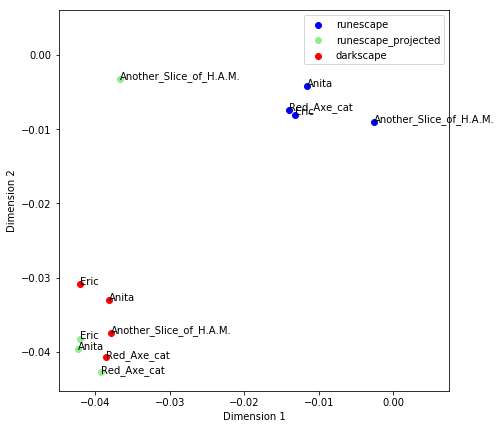

In [47]:
visualize_PCA(start=5, end=9, save_file="PCA_small.png")

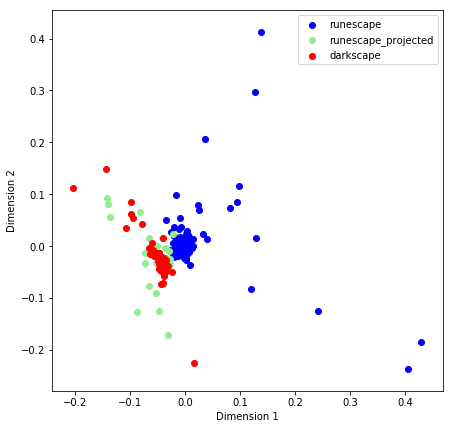

In [48]:
visualize_PCA(start=0, end=200, annotate=False, save_file="PCA_large.png")

#### Evaluation example

In [125]:
test_matrix_tgt_projected = projection.test_matrix_src @ projection.W
test_matrix_tgt_base = projection.test_matrix_tgt.copy()

test_matrix_tgt_projected = preprocessing.normalize(test_matrix_tgt_projected, axis=1, norm='l2')
test_matrix_tgt_base = preprocessing.normalize(test_matrix_tgt_base, axis=1, norm='l2')

size_tgt = test_matrix_tgt_projected.shape[1]
index = faiss.IndexFlatL2(size_tgt)
index.add(test_matrix_tgt_base.astype(np.float32))
D, I = index.search(test_matrix_tgt_projected.astype(np.float32), 20)

In [126]:
example_token = '<http://dbkwik.webdatacommons.org/darkscape/resource/Slaughtered_monk>'

def cleanse(token):
    pieces = token.split("/")
    return pieces[-2] + "/" + pieces[-1][:-1]

print(cleanse(example_token))

resource/Slaughtered_monk


In [127]:
I_names = [[cleanse(test_lexicon[j][1]) for j in line] for line in I]
I_corrects = [cleanse(test_lexicon[j][1]) for j in range(I.shape[0])]

In [128]:
# the top20 retrieved neighbors for the examples 170 to 180
I_names[170:180]

[['resource/Oak_bookcase',
  'resource/Rolo_the_Stout',
  'resource/Emir_Shah',
  'resource/Apprentice_Clara',
  'resource/Queen_Black_Dragon',
  'property/ability',
  'resource/Residead',
  'resource/Sir_Vyvin',
  'resource/Natural_pet_house',
  'resource/Leather_body_(Stealing_Creation)',
  'resource/Blurberry',
  'resource/Warhammer_(Stealing_Creation)',
  'resource/Bow_(Stealing_Creation)',
  'resource/Sagittarian_equipment',
  'property/logs',
  'resource/Dream_Mentor',
  'resource/Barlak',
  'resource/Wanderer',
  'resource/Platelegs_(Stealing_Creation)',
  'resource/Lady_Ithell'],
 ['resource/Robe_top_(Stealing_Creation)',
  'resource/Bow_(Stealing_Creation)',
  'resource/Leather_body_(Stealing_Creation)',
  'resource/Warhammer_(Stealing_Creation)',
  'resource/Platelegs_(Stealing_Creation)',
  'resource/Sagittarian_equipment',
  'resource/Blurberry',
  'resource/Queen_Black_Dragon',
  'resource/Ruby_key',
  'resource/Ernest_the_Chicken',
  'resource/Coif_(Stealing_Creation)',
 

In [129]:
# the actual correct entity for the examples 170 to 180, often among the suggested neighbors
I_corrects[170:180]

['resource/Rolo_the_Stout',
 'resource/Elite_black_platelegs',
 'resource/Throne_of_Miscellania',
 "resource/Nomad's_Requiem",
 'resource/Enhanced_excalibur',
 'resource/Phil',
 'property/custodian',
 'resource/Ward_of_subjugation',
 'resource/Peleas',
 'resource/Half-soulless']

In [130]:
top5_corpus = []
for line in I_names:
    top5_corpus += line[:5]

In [131]:
counts = Counter(top5_corpus)

In [132]:
counts_sorted = [(l, k) for k, l in sorted([(j, i) for i, j in counts.items()], reverse=True)]
sorted_words = [wc[0] for wc in counts_sorted]

In [133]:
counts_sorted

[('resource/Queen_Black_Dragon', 50),
 ('resource/Blurberry', 50),
 ('resource/Bow_(Stealing_Creation)', 37),
 ('resource/Barlak', 35),
 ('resource/Tetsu_helm', 34),
 ('resource/Robe_top_(Stealing_Creation)', 33),
 ('resource/Attuned_crystal_halberd', 29),
 ('resource/Residead', 27),
 ('resource/Enhanced_excalibur', 24),
 ("resource/Dodgy_Derek's_Dirty_Deals", 24),
 ('resource/Warhammer_(Stealing_Creation)', 23),
 ('resource/Ward_of_subjugation', 21),
 ('resource/Saradomin_sword', 21),
 ('resource/Royal_bolts', 21),
 ('resource/Smoking_Kills', 20),
 ('resource/Seasinger_makigai', 20),
 ('resource/Elnock_Inquisitor', 20),
 ('resource/Varrock_Sword_Shop', 19),
 ('resource/Flash_Powder_Factory', 19),
 ('resource/Abyssal_wand', 19),
 ('resource/Ring_of_death', 18),
 ('resource/Ernest_the_Chicken', 18),
 ('resource/Yadech_Strongarm', 17),
 ('resource/Trader', 17),
 ('resource/Sir_Vyvin', 17),
 ('resource/Karl', 17),
 ('resource/Zombie_(Surprise_Exam)', 16),
 ('resource/Armadyl_chestplate', 